# NLP Diasaster Tweets Project

## **Problem**
For this project, neural language processing will be used to analyze Tweets about natural disasters and predict if they refer to real disasters or not.

### **Data**
There are 3 files, train.csv, test.csv, and sample_submission.csv.
+ column descriptions:
    + id- unique identifier
    + keyword- keyword from tweet
    + location- location from which tweet was sent
    + text- tweet text
    + target- classifier, real tweet=1, not real=0

### **Exploratory Data Analysis (EDA)**

#### **Data Inspection**
+ train data:
    + 5 columns: id(int), keyword(object), location(object), text(object), target(int)
    + 7613 rows
+ test data:
    + 4 columns: id(int), keyword(object), location(object), text(object)
    + 3263 rows
+ sample submission:
    + 2 columns: id(int), target(int)
    + 3263 rows
+ There were no duplicates found in the data

In [21]:
# Import Packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout,GRU

In [2]:
# Import Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
samplesub= pd.read_csv('sample_submission.csv')

In [3]:
# Display dataframe
display(train.head())
# Display dataframe info
display(train.info())

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


None

In [4]:
# Display dataframe and info
display(test.head())
display(test.info())

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


None

In [5]:
# Display dataframe and info
display(samplesub.head())
display(samplesub.info())

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


None

#### **Data Visualizations**

+ Display category count to look at data balance:

target
0    4342
1    3271
Name: count, dtype: int64

<ipython-input-6-dc04f7466da7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data= train, x ='target', palette='mako')


Text(0.5, 1.0, 'Disaster Tweet Classes')

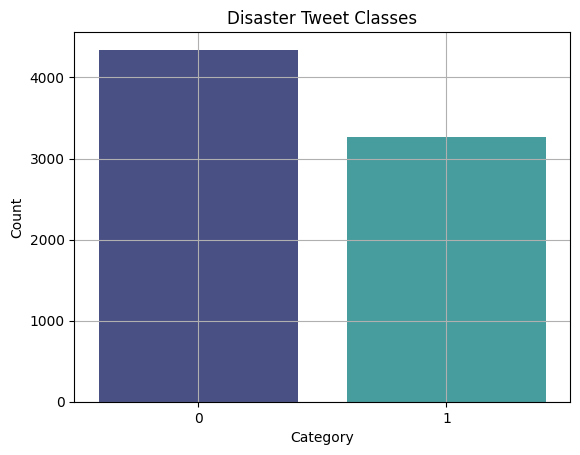

In [6]:
# Data balance:
train_count = train['target'].value_counts()
display(train_count)
sns.countplot(data= train, x ='target', palette='mako')
plt.grid(True)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Disaster Tweet Classes')

+ Display the top 20 keywords used:

In [7]:
trainsum = train.copy()
testsum = test.copy()
topwords = trainsum['keyword'].value_counts()[:20]
topwords = pd.DataFrame(topwords)
topwords

,count
keyword,
fatalities,45
deluge,42
armageddon,42
sinking,41
damage,41
harm,41
body%20bags,41
outbreak,40
evacuate,40


+ Histogram of text length by target values:

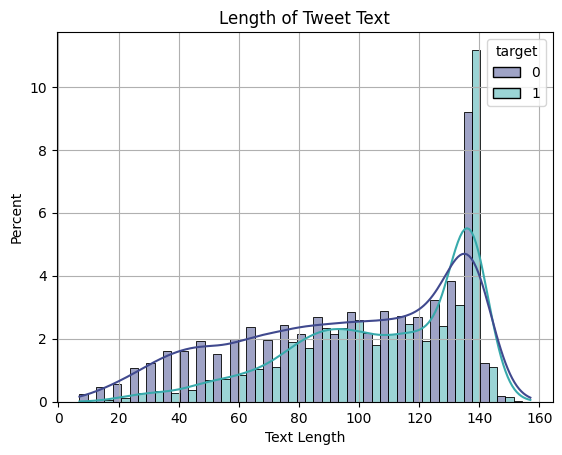

In [8]:
traindf = train.copy()
traindf['Text Length'] = traindf['text'].apply(len)
traindf = traindf.sort_values(by=['Text Length'], ascending=False)
sns.histplot(data=traindf, x='Text Length', hue='target', stat='percent', palette='mako', multiple='dodge',kde=True)
plt.title('Length of Tweet Text')
plt.grid()

+ Number of unique keywords and locations: 

In [9]:
print("Number of Unique Keywords in Train: ", train["keyword"].nunique())
print("Number of Unique Keywords in Test: ", test["keyword"].nunique())
print("*****")
print("Number of Unique Locations in Train: ", train["location"].nunique())
print("Number of Unique Locations in Test: ", test["location"].nunique())

Number of Unique Keywords in Train:  221
Number of Unique Keywords in Test:  221
*****
Number of Unique Locations in Train:  3341
Number of Unique Locations in Test:  1602


#### **Data Cleaning**

+ Remove duplicate values that was found in the text columns 

In [10]:
# Check for duplicates
print("Train id Duplicates: ")
display(sum(train.duplicated('id')))
print("Train text Duplicates: ")
display(sum(train.duplicated('text')))
# Check for duplicates
print("Test id Duplicates: ")
display(sum(test.duplicated('id')))
print("Test text Duplicates: ")
display(sum(test.duplicated('text')))

Train id Duplicates: 


0

Train text Duplicates: 


110

Test id Duplicates: 


0

Test text Duplicates: 


20

In [11]:
# Remove text duplicates and recalculate
train = train.drop_duplicates(subset='text')
test = test.drop_duplicates(subset='text')
print("Train text Duplicates: ")
display(sum(train.duplicated('text')))
print("Test text Duplicates: ")
display(sum(test.duplicated('text')))

Train text Duplicates: 


0

Test text Duplicates: 


0

* Clean the text columns for train and test data for the model by making all letters lowercase, removing numbers and punctuation, and removing html, url, and hashtags/@ symbols:

In [13]:
# make lowercase
train['text'] = train['text'].str.lower()
# remove numbers
train['text'] = train['text'].apply(lambda row: re.sub(r'[0-9]+', '', row))
# remove punctuation
train['text'] = train['text'].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
# remove html
train['text'] = train['text'].apply(lambda row: re.sub(r'&.*?;|<.*?>', '', row))
# remove url
train['text'] = train['text'].apply(lambda row: re.sub(r'https?://\S+|www\.\S+', '', row))
# remove hashtags
train['text'] = train['text'].apply(lambda row: re.sub(r'@([a-z0-9]+)|#', '', row))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [14]:
# make lowercase
test['text'] = test['text'].str.lower()
# remove numbers
test['text'] = test['text'].apply(lambda row: re.sub(r'[0-9]+', '', row))
# remove punctuation
test['text'] = test['text'].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
# remove html
test['text'] = test['text'].apply(lambda row: re.sub(r'&.*?;|<.*?>', '', row))
# remove url
test['text'] = test['text'].apply(lambda row: re.sub(r'https?://\S+|www\.\S+', '', row))
# remove hashtags
test['text'] = test['text'].apply(lambda row: re.sub(r'@([a-z0-9]+)|#', '', row))
test.head()

,id,keyword,location,text
0,0,NaN,NaN,just happened a terrible car crash
1,2,NaN,NaN,heard about earthquake is different cities sta...
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills in china and taiwan


### **Model Architecture**

Before fitting the data for models, tokenize the text data and split into train and validation data. Two types of models will be fit, LSTM and GRU. Long Short Term Memory (LSTM) is a recurrent neural network that reduces the vanishing gradient problem. Gated Recurrent Unit (GRU) is similiar to LSTM, but less complex ith 2 gates instead of 3 in LSTM. The architecture for both will be very similar to see if there is a significant difference between the two. 

In [18]:
# Tokenize data
tokenizer = Tokenizer(num_words = 3000, split=' ')
tokenizer.fit_on_texts(train['text'].values)
X = tokenizer.texts_to_sequences(train['text'].values)
X = pad_sequences(X)

In [76]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, train['target'], test_size=0.2, random_state=321)

+ **LSTM**

In [25]:
# LSTM Model
lstm = Sequential()
lstm.add(Embedding(3000, 128, input_length=X_train.shape[1]))
lstm.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 31, 128)           384000    
                                                                 
 lstm_2 (LSTM)               (None, 32)                20608     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 404641 (1.54 MB)
Trainable params: 404641 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# Fit the model
history = lstm.fit(x = X_train, y = y_train, epochs = 10, validation_data = (X_test, y_test), verbose = 2)

Epoch 1/10
188/188 - 15s - loss: 0.5398 - accuracy: 0.7263 - val_loss: 0.4420 - val_accuracy: 0.8135 - 15s/epoch - 79ms/step
Epoch 2/10
188/188 - 9s - loss: 0.3644 - accuracy: 0.8449 - val_loss: 0.4637 - val_accuracy: 0.8021 - 9s/epoch - 46ms/step
Epoch 3/10
188/188 - 10s - loss: 0.3052 - accuracy: 0.8779 - val_loss: 0.4944 - val_accuracy: 0.7995 - 10s/epoch - 53ms/step
Epoch 4/10
188/188 - 10s - loss: 0.2582 - accuracy: 0.9014 - val_loss: 0.5396 - val_accuracy: 0.7841 - 10s/epoch - 54ms/step
Epoch 5/10
188/188 - 8s - loss: 0.2125 - accuracy: 0.9190 - val_loss: 0.5901 - val_accuracy: 0.7861 - 8s/epoch - 45ms/step
Epoch 6/10
188/188 - 12s - loss: 0.1741 - accuracy: 0.9347 - val_loss: 0.7199 - val_accuracy: 0.7761 - 12s/epoch - 66ms/step
Epoch 7/10
188/188 - 10s - loss: 0.1428 - accuracy: 0.9454 - val_loss: 0.8111 - val_accuracy: 0.7788 - 10s/epoch - 55ms/step
Epoch 8/10
188/188 - 10s - loss: 0.1167 - accuracy: 0.9548 - val_loss: 0.9902 - val_accuracy: 0.7648 - 10s/epoch - 52ms/step
Epoc

 *Plot Accuracy and Loss Results:*

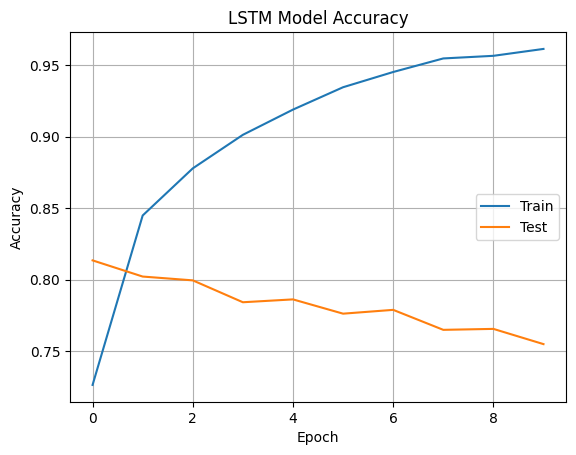

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='right')
plt.grid()
plt.show()

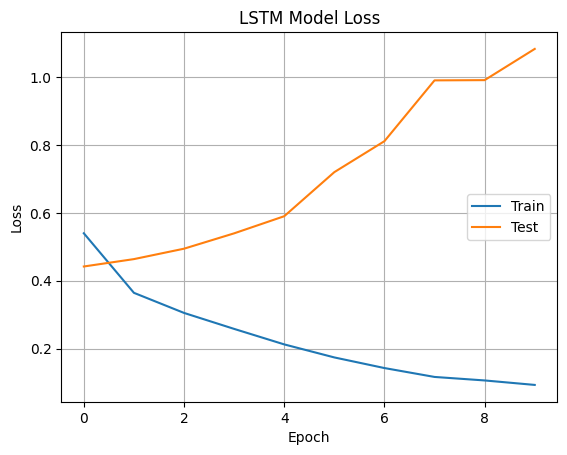

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='right')
plt.grid()
plt.show()

+ **GRU**

In [27]:
gru = Sequential()
gru.add(Embedding(3000, 128, input_length=X_train.shape[1]))
gru.add(GRU(32, dropout=0.2, recurrent_dropout=0.2))
gru.add(Dense(1, activation='sigmoid'))
gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 31, 128)           384000    
                                                                 
 gru (GRU)                   (None, 32)                15552     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 399585 (1.52 MB)
Trainable params: 399585 (1.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
historygru = gru.fit(x = X_train, y = y_train, epochs = 10, validation_data = (X_test, y_test), verbose = 2)

Epoch 1/10
188/188 - 11s - loss: 0.5519 - accuracy: 0.7129 - val_loss: 0.4639 - val_accuracy: 0.7995 - 11s/epoch - 58ms/step
Epoch 2/10
188/188 - 12s - loss: 0.3676 - accuracy: 0.8459 - val_loss: 0.4710 - val_accuracy: 0.7968 - 12s/epoch - 62ms/step
Epoch 3/10
188/188 - 13s - loss: 0.3072 - accuracy: 0.8734 - val_loss: 0.5098 - val_accuracy: 0.7895 - 13s/epoch - 68ms/step
Epoch 4/10
188/188 - 13s - loss: 0.2566 - accuracy: 0.8979 - val_loss: 0.5768 - val_accuracy: 0.7788 - 13s/epoch - 68ms/step
Epoch 5/10
188/188 - 8s - loss: 0.2154 - accuracy: 0.9144 - val_loss: 0.6736 - val_accuracy: 0.7781 - 8s/epoch - 45ms/step
Epoch 6/10
188/188 - 6s - loss: 0.1806 - accuracy: 0.9322 - val_loss: 0.6837 - val_accuracy: 0.7615 - 6s/epoch - 34ms/step
Epoch 7/10
188/188 - 9s - loss: 0.1505 - accuracy: 0.9455 - val_loss: 0.7796 - val_accuracy: 0.7668 - 9s/epoch - 49ms/step
Epoch 8/10
188/188 - 7s - loss: 0.1307 - accuracy: 0.9513 - val_loss: 0.8456 - val_accuracy: 0.7675 - 7s/epoch - 35ms/step
Epoch 9/

 *Plot Accuracy and Loss Results:*

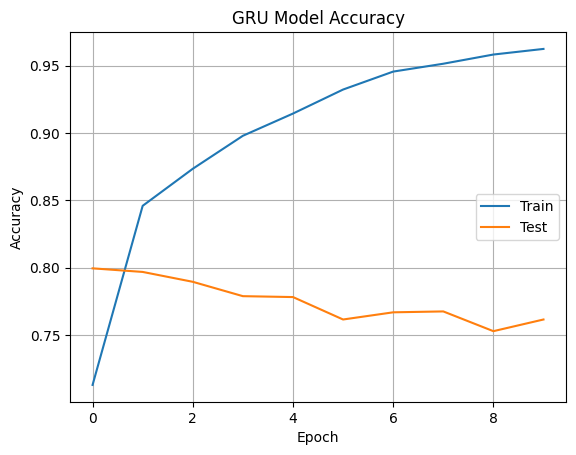

In [35]:
plt.plot(historygru.history['accuracy'])
plt.plot(historygru.history['val_accuracy'])
plt.title('GRU Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='right')
plt.grid()
plt.show()

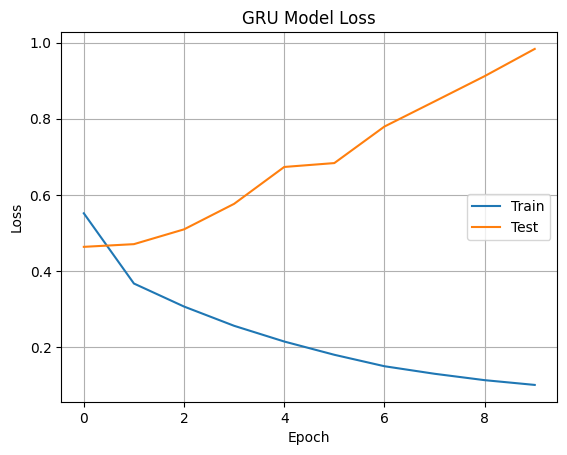

In [39]:
plt.plot(historygru.history['loss'])
plt.plot(historygru.history['val_loss'])
plt.title('GRU Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='right')
plt.grid()
plt.show()

### **Results and Analysis**
Because the GRU model had the higher accuracy, I adjusted the filter layers to see if performance would improve. There was minimal improvement with the original GRU model having the highest accuracy values. 

In [49]:
gru2 = Sequential()
gru2.add(Embedding(3000, 128, input_length=X_train.shape[1]))
gru2.add(GRU(64, dropout=0.2, recurrent_dropout=0.2))
gru2.add(Dense(1, activation='sigmoid'))
gru2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 31, 128)           384000    
                                                                 
 gru_4 (GRU)                 (None, 64)                37248     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 421313 (1.61 MB)
Trainable params: 421313 (1.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
historygru2 = gru2.fit(x = X_train, y = y_train, epochs = 10, batch_size = 64, validation_data = (X_test, y_test))

Epoch 1/10
94/94 [==============================] - 12s 93ms/step - loss: 0.5725 - accuracy: 0.6919 - val_loss: 0.4587 - val_accuracy: 0.8001
Epoch 2/10
94/94 [==============================] - 6s 64ms/step - loss: 0.3717 - accuracy: 0.8441 - val_loss: 0.4816 - val_accuracy: 0.7841
Epoch 3/10
94/94 [==============================] - 8s 86ms/step - loss: 0.3056 - accuracy: 0.8729 - val_loss: 0.5232 - val_accuracy: 0.7815
Epoch 4/10
94/94 [==============================] - 6s 68ms/step - loss: 0.2643 - accuracy: 0.8940 - val_loss: 0.5847 - val_accuracy: 0.7801
Epoch 5/10
94/94 [==============================] - 7s 76ms/step - loss: 0.2246 - accuracy: 0.9122 - val_loss: 0.6668 - val_accuracy: 0.7748
Epoch 6/10
94/94 [==============================] - 5s 58ms/step - loss: 0.1980 - accuracy: 0.9234 - val_loss: 0.6916 - val_accuracy: 0.7635
Epoch 7/10
94/94 [==============================] - 6s 67ms/step - loss: 0.1648 - accuracy: 0.9387 - val_loss: 0.7990 - val_accuracy: 0.7728
Epoch 8/10
9

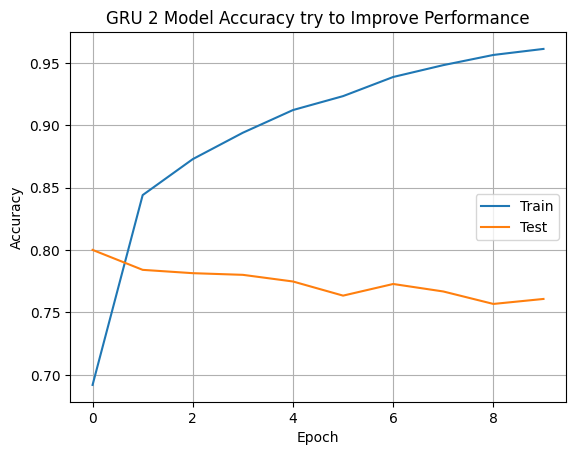

In [51]:
plt.plot(historygru2.history['accuracy'])
plt.plot(historygru2.history['val_accuracy'])
plt.title('GRU 2 Model Accuracy try to Improve Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='right')
plt.grid()
plt.show()

In [53]:
print("LSTM Accuracy:", history.history['accuracy'][-1])
print("GRU Accuracy:", historygru.history['accuracy'][-1])
print("GRU2 Accuracy:", historygru2.history['accuracy'][-1])

LSTM Accuracy: 0.9615128040313721
GRU Accuracy: 0.9623458981513977
GRU2 Accuracy: 0.9611796140670776


In [78]:
pred = gru2.predict(X_train)
pred = pred.round().astype('int')
pred = pd.DataFrame(pred, columns=['preds'])

188/188 [==============================] - 1s 6ms/step


In [74]:
submission['target'] = pred
submission.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3243 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3243 non-null   int64
 1   target  3243 non-null   int64
dtypes: int64(2)
memory usage: 76.0 KB


In [77]:
submission.to_csv("submission2.csv", index=False, header=True)

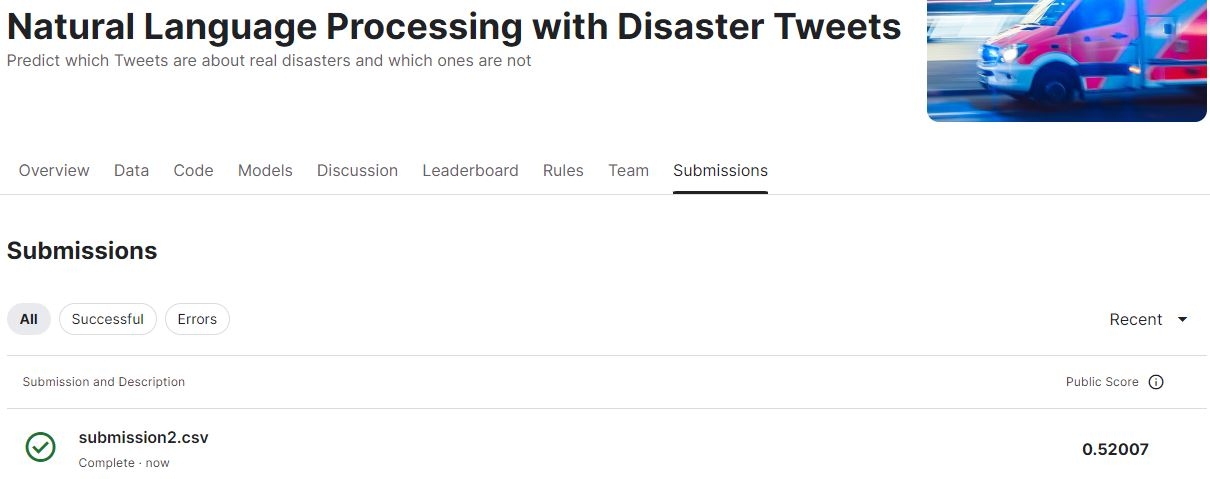

### **Conclusion**
+ They all performed simlarly well at around a 0.96 accuracy. The results of the submission into competition are included above, showing a score of 0.52 which doesn't reflect the higher accuracy scores. 
+ While the models performed well with the train data, the test data did not perform well and more investigation into the cause is warranted. It may help to adjust the dense or dropout layer values, or reevaulate the text embedding techniques used. The models may have also been overfitting the data and resulting in poor test results. 
